## Compartment model, mean response D-optimal

In [1]:
using PyPlot
using LinearAlgebra

#objective function h to minimize
function infmat(x)
    n = Int((length(x)+1)/2)
    a = x[1:n]q
    b = x[(n+1):(2*n-1)]
    b = [b; 1-sum(b)]
    p = length(theta)
    mat = zeros(p,p)
    for i in 1:n
        c1 = a[i]*theta[3]*exp(-theta[1]*a[i])
        c2 = -a[i]*theta[3]*exp(-theta[2]*a[i]) 
        c3 = exp(-theta[2]*a[i])-exp(-theta[1]*a[i])
        f = [c1, c2, c3]
        mat = mat + b[i] .* f*f'
    end
    return mat
end

# projection function onto the design space
function proj(x, design)
    n = Int((length(x)+1)/2)
    a = x[1:n]
    b = x[(n+1):(2*n-1)]
    b = [b; 1-sum(b)]
    
    a = max.(a,design[1])
    a = min.(a,design[2])
    
    u = sort(b, rev=true)
    j = n
    while true
        if u[j] + 1/j*(1-cumsum(u)[j]) > 0
            break
        end
        j -= 1
    end
    lambda = 1/j*(1-cumsum(u)[j])
    b = max.(b .+ lambda,0)
    b = b[1:(n-1)]
    
    return [a;b]
end

proj (generic function with 1 method)

In [2]:
function diter()
    #initialize
    #srand(1992)
    path = zeros(niter)
    tau = 0.9:(-0.5/niter):0.4
    v = zeros(nptc, 2k-1)
    x = (design[2]-design[1])*rand(nptc*k) .+ design[1]
    x = reshape(x,nptc,k)
    w = rand(nptc*(k-1))
    w = reshape(w,nptc,k-1)
    ptc = hcat(x,w)
    for j in 1:nptc
        ptc[j,:] = proj(ptc[j,:],design)
    end
    pbest = ptc
    pbesth = zeros(nptc)
    for i in 1:nptc
        pbesth[i] = det(infmat(pbest[i,:]))
    end
    gbesth = findmax(pbesth)[1]
    gbest = pbest[findmax(pbesth)[2],:]

    #iterate
    t1 = time_ns()
    for i in 1:niter # iteration number
        for j in 1:nptc # particle number
            v[j,:] = tau[i] .*v[j,:] + 2 .*rand(2k-1) .*(pbest[j,:]-ptc[j,:]) + 2 .*rand(2k-1) .*(gbest-ptc[j,:])
            ptc[j,:] = ptc[j,:] + v[j,:]
            ptc[j,:] = proj(ptc[j,:],design)
            fit = det(infmat(ptc[j,:]))
            if fit > gbesth
                gbest = pbest[j,:] = ptc[j,:]
                gbesth = pbesth[j] = fit
            elseif fit > pbesth[j]
                pbest[j,:] = ptc[j,:]
                pbesth[j] = fit
            end
        end
        path[i] = gbesth
    end
    t2 = time_ns()
    supp = gbest[1:k]
    prob = gbest[(k+1):2k-1]
    prob = [prob; 1-sum(prob)]
    plt = plot(1:niter, path, color="red", linewidth=2.0, linestyle="solid")
    cput = (t2-t1)/10^9
    return [supp, prob, cput, path[niter], path[niter] - path[niter-Int(0.1*niter)], plot]
end

diter (generic function with 1 method)

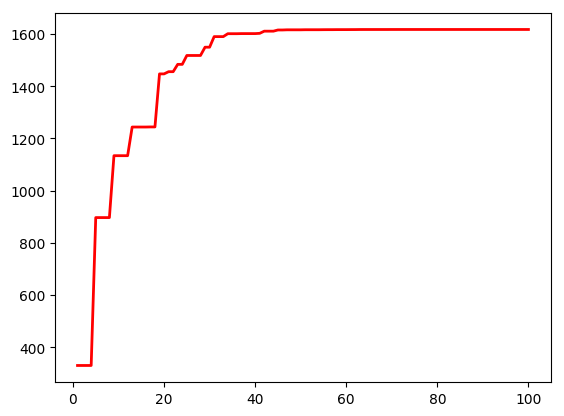

6-element Array{Any,1}:
     [0.228772, 1.38858, 18.4168]  
     [0.333331, 0.333334, 0.333335]
    0.752974632                    
 1617.5895386473808                
    6.254030950003653e-6           
     PyPlot.plot                   

In [3]:
theta = [0.05884, 4.298, 21.8]
k = 3
nptc = 100
niter = 100
design = [0,30]

result = diter()

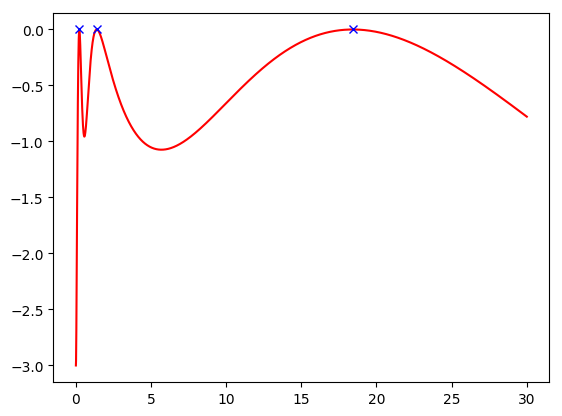

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe5750c1668>
 PyObject <matplotlib.lines.Line2D object at 0x7fe5750c1908>

In [4]:
x = result[1]
w = result[2]
mat = zeros(3,3)
for i in 1:3
    c1 = x[i]*theta[3]*exp(-theta[1]*x[i])
    c2 = -x[i]*theta[3]*exp(-theta[2]*x[i]) 
    c3 = exp(-theta[2]*x[i])-exp(-theta[1]*x[i])
    f = [c1, c2, c3]
    mat = mat + w[i] .* f*f'
end
mati = inv(mat)

function equiv(x)
    c1 = x*theta[3]*exp(-theta[1]*x)
    c2 = -x*theta[3]*exp(-theta[2]*x) 
    c3 = exp(-theta[2]*x)-exp(-theta[1]*x)
    f = [c1, c2, c3]
    val = f' *mati*f - 3
    return val
end

dp = 0:0.01:30
plot(dp, equiv.(dp), "r-",x, equiv.(x), "bx")

## Compartment model, time to max concentration, c-optimal

In [5]:
diagm(ones(3))

MethodError: MethodError: no method matching diagm(::Array{Float64,1})
Closest candidates are:
  diagm(!Matched::Pair{#s623,#s622} where #s622<:(AbstractArray{T,1} where T) where #s623<:Integer...) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/LinearAlgebra/src/dense.jl:291

In [6]:
#objective function h
function h(x, c)
    mat = infmat(x)
    m = size(mat)[1]
    mat = mat + 10.0^-6* Diagonal(ones(m,m))
    return c' * inv(mat)* c
end

h (generic function with 1 method)

In [7]:
function citer()
    #initialize
    #srand(1992)
    path = zeros(niter)
    tau = 0.9:(-0.5/niter):0.4
    v = zeros(nptc, 2k-1)
    x = (design[2]-design[1])*rand(nptc*k) .+ design[1]
    x = reshape(x,nptc,k)
    w = rand(nptc*(k-1))
    w = reshape(w,nptc,(k-1))
    ptc = hcat(x,w)
    for j in 1:nptc
        ptc[j,:] = proj(ptc[j,:],design)
    end
    pbest = ptc
    pbesth = zeros(nptc)
    for i in 1:nptc
        pbesth[i] = h(pbest[i,:],c)
    end
    gbesth = findmin(pbesth)[1]
    gbest = pbest[findmin(pbesth)[2],:]

    #iterate
    t1 = time_ns()
    for i in 1:niter # iteration number
        for j in 1:nptc # particle number
            v[j,:] = tau[i] .*v[j,:] + 2 .*rand(2k-1) .*(pbest[j,:]-ptc[j,:]) + 2 .*rand(2k-1) .*(gbest-ptc[j,:])
            ptc[j,:] = ptc[j,:] + v[j,:]
            ptc[j,:] = proj(ptc[j,:], design)
            fit = h(ptc[j,:],c)
            if fit[1] < gbesth
                gbest = pbest[j,:] = ptc[j,:]
                gbesth = pbesth[j] = fit[1]
            elseif fit[1] < pbesth[j]
                pbest[j,:] = ptc[j,:]
                pbesth[j] = fit[1]
            end
        end
        path[i] = gbesth
    end
    t2 = time_ns()
    supp = gbest[1:k]
    prob = gbest[(k+1):2k-1]
    prob = [prob; 1-sum(prob)]
    plt = plot(1:niter, path, color="red", linewidth=2.0, linestyle="solid")
    cput = (t2-t1)/10^9
    return [supp, prob, cput, path[niter], path[niter] - path[niter-Int(0.1*niter)], plot]
end

citer (generic function with 1 method)

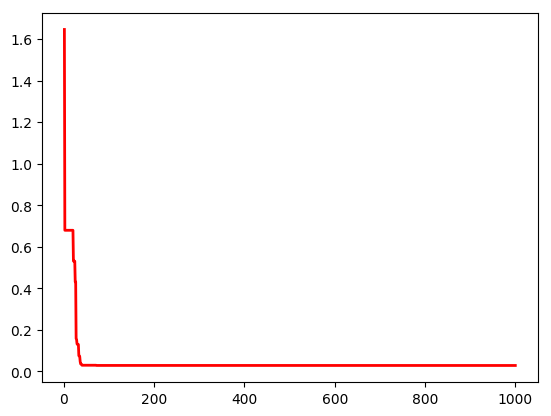

6-element Array{Any,1}:
  [0.179287, 3.56584]
  [0.60616, 0.39384] 
 6.107893264         
 0.02813827777749505 
 0.0                 
  PyPlot.plot        

In [8]:
theta = [0.05884, 4.298, 21.8]
k = 2
nptc = 200
niter = 1000
design = [0,10]

#derivative of function c(theta)
c = zeros(3)
c[1] = (1 - theta[2]/theta[1] - log(theta[1]) + log(theta[2])) / (theta[2]-theta[1])^2
c[2] = (1 - theta[1]/theta[2] - log(theta[2]) + log(theta[1])) / (theta[2]-theta[1])^2

citer()

## Compartment model, AUC, c-optimal

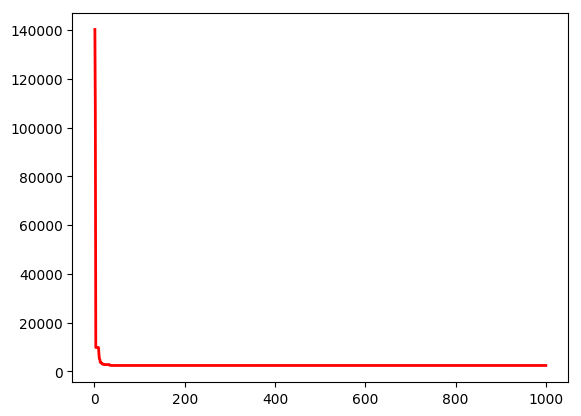

6-element Array{Any,1}:
     [0.870567, 20.0]     
     [0.0533833, 0.946617]
    3.121633449           
 2412.7398330961864       
    0.0                   
     PyPlot.plot          

In [9]:
theta = [0.05884, 4.298, 21.8]
k = 2
nptc = 100
niter = 1000
design = [0,20]

#derivative of function c(theta)
c = zeros(3)
c[1] = theta[3]/theta[1]^2
c[2] = -theta[3]/theta[2]^2
c[3] = 1/theta[2] - 1/theta[1]

citer()

## Compartment model, AUC, c-optimal What if design is [0,30]?

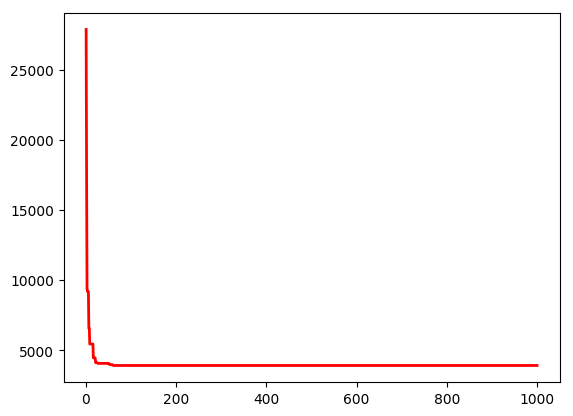

6-element Array{Any,1}:
     [30.0, 1.20702]     
     [0.871558, 0.128442]
    2.954918251          
 3909.5132867640705      
    0.0                  
     PyPlot.plot         

In [10]:
theta = [0.05884, 4.298, 21.8]
k = 2
nptc = 100
niter = 1000
design = [0,30]

citer()

## Compartment model, AUC, c-optimal (k=3)

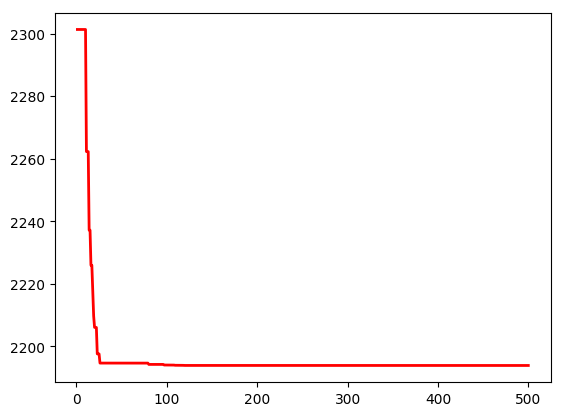

6-element Array{Any,1}:
     [0.232668, 20.0, 17.634]  
     [0.0135025, 0.0, 0.986497]
    3.182330913                
 2193.8839298985063            
    0.0                        
     PyPlot.plot               

In [11]:
theta = [0.05884, 4.298, 21.8]
k = 3
nptc = 200
niter = 500
design = [0,20]

citer()

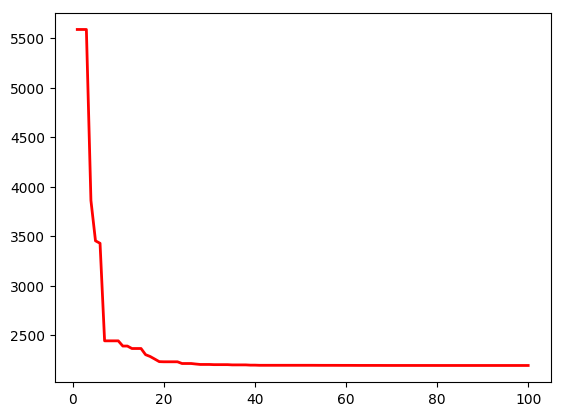

6-element Array{Any,1}:
     [17.634, 0.232667, 20.0]  
     [0.986472, 0.0135279, 0.0]
    0.328720445                
 2193.8840372473464            
   -0.0006101983371991082      
     PyPlot.plot               

In [12]:
theta = [0.05884, 4.298, 21.8]
k = 3
nptc = 100
niter = 100
design = [0,20]

citer()

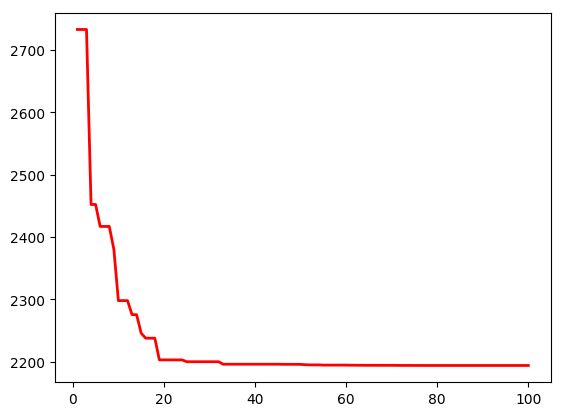

6-element Array{Any,1}:
     [20.0, 20.0, 0.232682, 17.634] 
     [0.0, 0.0, 0.0135046, 0.986495]
    0.341784566                     
 2193.883930920488                  
   -0.0001933535518219287           
     PyPlot.plot                    

In [13]:
theta = [0.05884, 4.298, 21.8]
k = 4
nptc = 100
niter = 100
design = [0,20]

citer()

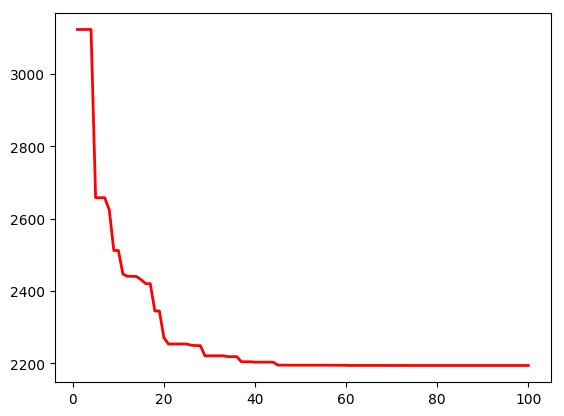

6-element Array{Any,1}:
     [20.0, 20.0, 0.232743, 17.6341, 20.0]       
     [0.0, 0.0, 0.0135189, 0.986481, 1.11022e-16]
    0.35968717                                   
 2193.883977890121                               
   -2.5511405965517042e-5                        
     PyPlot.plot                                 

In [14]:
theta = [0.05884, 4.298, 21.8]
k = 5
nptc = 100
niter = 100
design = [0,20]

citer()

## Quadratic Logistic Model, d-optimal

In [15]:
#Information matrix for quadratic logistic model
function infmat(x)
    n = Int((length(x)+1)/2)
    a = x[1:n]
    b = x[(n+1):(2*n-1)]
    b = [b; 1-sum(b)]
    p = length(theta)
    mat = zeros(p,p)
    for i in 1:n
        c = exp(theta[1]+theta[2]*(a[i]-theta[3])^2)
        f = [1,(a[i]-theta[3])^2,2*theta[2]*(theta[3]-a[i]) ]
        mat = mat + b[i] * c/(1+c)^2 * f*f'
    end
    return mat
end

infmat (generic function with 1 method)

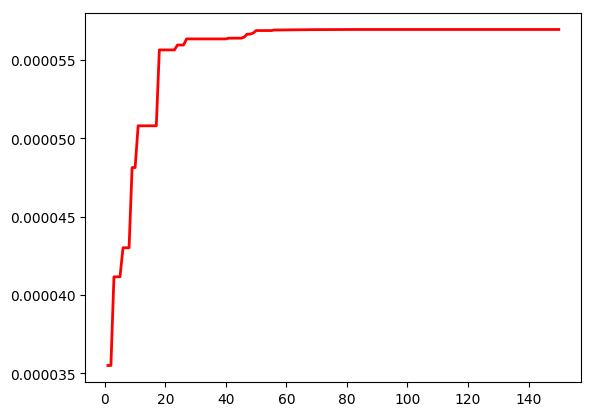

6-element Array{Any,1}:
  [0.726988, -0.726988, -2.8581e-8]
  [0.333333, 0.333333, 0.333333]   
 0.70091292                        
 5.694646494958811e-5              
 9.293645497274183e-17             
  PyPlot.plot                      

In [16]:
theta = [2,3,0]
design = [-3,1]
k = 3
nptc = 128
niter =150

diter()

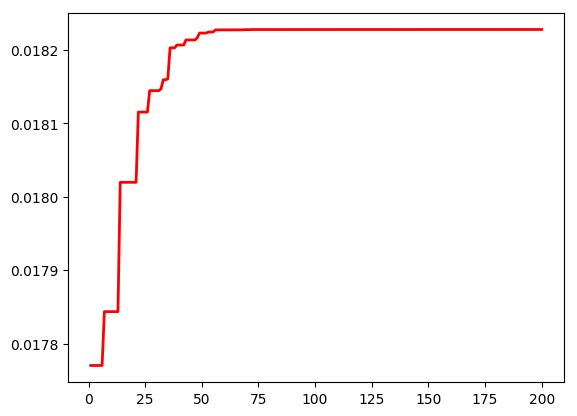

6-element Array{Any,1}:
  [-0.848815, 0.57935, 1.0, 1.0]            
  [0.333333, 0.333333, 0.333329, 3.87011e-6]
 1.963065281                                
 0.018228167200968277                       
 0.0                                        
  PyPlot.plot                               

In [17]:
theta = [3,-5,0]
design = [-1,1]
k = 4
nptc = 256
niter = 200

result = diter()

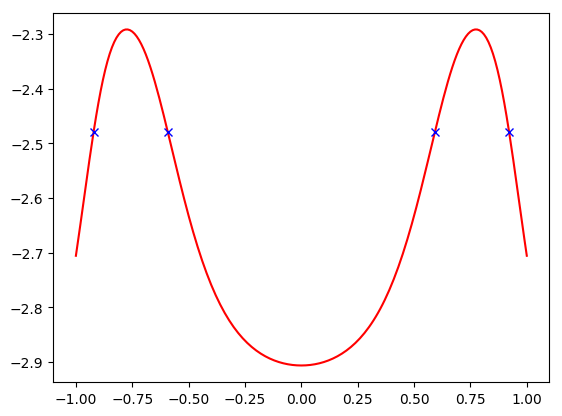

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe572e81710>
 PyObject <matplotlib.lines.Line2D object at 0x7fe572e812b0>

In [18]:
x = [0.921666, -0.921666, 0.592057, -0.592057]
w = [0.296564, 0.296564, 0.203436, 0.203436]
mat = zeros(3,3)
for i in 1:4
    c = exp(theta[1]+theta[2]*(x[i]-theta[3])^2)
    f = [1,(x[i]-theta[3])^2,2*theta[2]*(theta[3]-x[i]) ]
    mat = mat + w[i] * c/(1+c)^2 * f*f'
end
mati = inv(mat)

function equiv(x)
    c = exp(theta[1]+theta[2]*(x-theta[3])^2)
    f = [1,(x-theta[3])^2,2*theta[2]*(theta[3]-x) ]
    val = (c/(1+c)^2)^2 * f' *mati* f - 3
    return val
end

dp = -1:0.01:1
plot(dp, equiv.(dp), "r-",x, equiv.(x), "bx")